In [11]:
from jax import random, jit, vmap
import os
path = os.getcwd()
print("Old path:", path)
path+='/ABC-SBI'
path = (path.split('/'))
if path.index("ABC-SBI")==-1:
    path.append('ABC-SBI')
    
path = path[:path.index("ABC-SBI")+1]
path = '/'.join(path)
print("New path:", path)
os.chdir(path)

import sys
sys.path.append(path)
from functions.simulation import get_dataset, get_epsilon_star, get_newdataset
from functions.training import train_loop
from functions.SBC import SBC_epsilon, plot_SBC
import jax.numpy as jnp
import time
import pickle 
import lzma
from jax.scipy.special import expit
import json 
import numpy as np


data = json.load(open(path+"/examples/POTUS-nat/data/potus_data.json"))

np_data = {x: np.squeeze(np.array(y)) for x, y in data.items()}

shapes = {
    "N_national_polls": int(np_data["N_national_polls"]),
    "N_state_polls": int(np_data["N_state_polls"]),
    "T": int(np_data["T"]),
    "S": int(np_data["S"]),
    "P": int(np_data["P"]),
    "M": int(np_data["M"]),
    "Pop": int(np_data["Pop"]),
}


national_cov_matrix_error_sd = np.sqrt(
    np.squeeze(
        np_data["state_weights"].reshape(1, -1)
        @ (np_data["state_covariance_0"] @ np_data["state_weights"].reshape(-1, 1))
    )
)

ss_cov_poll_bias = (
    np_data["state_covariance_0"]
    * (np_data["polling_bias_scale"] / national_cov_matrix_error_sd) ** 2
)

ss_cov_mu_b_T = (
    np_data["state_covariance_0"]
    * (np_data["mu_b_T_scale"] / national_cov_matrix_error_sd) ** 2
)

ss_cov_mu_b_walk = (
    np_data["state_covariance_0"]
    * (np_data["random_walk_scale"] / national_cov_matrix_error_sd) ** 2
)

cholesky_ss_cov_poll_bias = np.linalg.cholesky(ss_cov_poll_bias)
cholesky_ss_cov_mu_b_T = np.linalg.cholesky(ss_cov_mu_b_T)
cholesky_ss_cov_mu_b_walk = np.linalg.cholesky(ss_cov_mu_b_walk)

i, j = np.indices((np_data["T"], np_data["T"]))
mask = np.tril(np.ones((np_data["T"], np_data["T"])))

y_obs_state = np_data["n_democrat_state"]
y_obs_nat = np_data["n_democrat_national"]

mu_b_T_loc_prior = np.dot(np_data["mu_b_prior"].T,np_data["state_weights"])
mu_b_T_scale_prior = np.dot(np.dot(np_data["state_weights"].T,ss_cov_mu_b_T),np_data["state_weights"])



MU_B_T_PRIOR = np_data["mu_b_prior"]
SIGMA_MU_B_T = ss_cov_mu_b_T
WEIGHT_STATE = np_data["state_weights"][None,:]
CHOL_SIGMA_MU_B_T = cholesky_ss_cov_mu_b_T
VAR_MU_T_NAT = jnp.dot(jnp.dot(WEIGHT_STATE, SIGMA_MU_B_T), WEIGHT_STATE.T)
C_COND = jnp.dot(SIGMA_MU_B_T, WEIGHT_STATE.T) / VAR_MU_T_NAT
A_COND = jnp.eye(SIGMA_MU_B_T.shape[0]) - jnp.dot(C_COND, WEIGHT_STATE)
CHOL_SIGMA_MU_B_T_GIVEN_MU_NAT = jnp.dot(A_COND, CHOL_SIGMA_MU_B_T)



@jit 
def prior_simulator(key):
    return random.normal(key, (1,))*jnp.sqrt(mu_b_T_scale_prior) + mu_b_T_loc_prior


@jit
def data_simulator(key, theta):
    raw_polling_bias = random.normal(key, (shapes["S"],))
    raw_mu_b_T = random.normal(key, (shapes["S"],))
    raw_mu_b = random.normal(key, (shapes["S"], shapes["T"]))
    raw_mu_c = random.normal(key, (shapes["P"],))
    raw_mu_m = random.normal(key, (shapes["M"],))
    raw_mu_pop = random.normal(key, (shapes["Pop"],))
    
    mu_e_bias = random.normal(key, ()) * 0.02
    loc, scale = 0.7, 0.1
    low, high = (0 - loc) / scale, (1 - loc) / scale
    rho_e_bias = random.truncated_normal(key, low, high)*scale + loc
    raw_e_bias = random.normal(key, (shapes["T"],))
    
    raw_measure_noise_national = random.normal(key, (shapes["N_national_polls"],))
    # raw_measure_noise_state = random.normal(key, (shapes["N_state_polls"],))
    
    polling_bias = jnp.dot(cholesky_ss_cov_poll_bias, raw_polling_bias)
    national_polling_bias_average = jnp.sum(polling_bias * np_data["state_weights"])
    
    
    # mu_b_T = jnp.dot(cholesky_ss_cov_mu_b_T, raw_mu_b_T) + np_data["mu_b_prior"] 
    mu_b_T = jnp.dot(CHOL_SIGMA_MU_B_T_GIVEN_MU_NAT, raw_mu_b_T) + jnp.dot(A_COND, MU_B_T_PRIOR) + C_COND[:,0]*theta   
    mus_b_without_last = jnp.dot(cholesky_ss_cov_mu_b_walk, raw_mu_b[:, :-1])[:, ::-1]
    mus_b = jnp.concatenate([mu_b_T.reshape(-1, 1), mus_b_without_last], axis=1)
    mus_b = jnp.cumsum(mus_b, axis=1)[:,::-1]
    national_mu_b_average = jnp.dot(mus_b.T, np_data["state_weights"].reshape(-1, 1))[:, 0]

    # print("National mu_b average ", national_mu_b_average[-1], jnp.dot(mu_b_T, np_data["state_weights"].reshape(-1, 1))[0],
    #       np.allclose(national_mu_b_average[-1],jnp.dot(mu_b_T, np_data["state_weights"].reshape(-1, 1))[0]))
    mu_c = raw_mu_c * np_data["sigma_c"]
    mu_m = raw_mu_m * np_data["sigma_m"]
    mu_pop = raw_mu_pop * np_data["sigma_pop"]

    # e_bias_init = raw_e_bias[0] * np_data["sigma_e_bias"]
    sigma_rho = jnp.sqrt(1 - (rho_e_bias ** 2)) * np_data["sigma_e_bias"]
    sigma_vec = jnp.append(np_data["sigma_e_bias"], jnp.repeat(sigma_rho, shapes["T"] - 1))
    mus = jnp.append(jnp.zeros(1), jnp.repeat(mu_e_bias * (1 - rho_e_bias), shapes["T"] - 1))
    A_inv = mask * (rho_e_bias ** (jnp.abs(i - j)))
    e_bias = jnp.dot(A_inv, sigma_vec * raw_e_bias + mus)


    # Minus ones shenanigans required for different indexing
    # logit_pi_democrat_state = (
    #     mus_b[np_data["state"] - 1, np_data["day_state"] - 1]
    #     + mu_c[np_data["poll_state"] - 1]
    #     + mu_m[np_data["poll_mode_state"] - 1]
    #     + mu_pop[np_data["poll_pop_state"] - 1]
    #     + np_data["unadjusted_state"] * e_bias[np_data["day_state"] - 1]
    #     + raw_measure_noise_state * np_data["sigma_measure_noise_state"]
    #     + polling_bias[np_data["state"] - 1]
    # )

    logit_pi_democrat_national = (
        national_mu_b_average[np_data["day_national"] - 1]
        + mu_c[np_data["poll_national"] - 1]
        + mu_m[np_data["poll_mode_national"] - 1]
        + mu_pop[np_data["poll_pop_national"] - 1]
        + np_data["unadjusted_national"] * e_bias[np_data["day_national"] - 1]
        + raw_measure_noise_national * np_data["sigma_measure_noise_national"]
        + national_polling_bias_average
    )

    # prob_state = expit(logit_pi_democrat_state)
    prob_nat = expit(logit_pi_democrat_national)

    # y_state = random.binomial(key, np_data["n_two_share_state"], prob_state)
    y_nat = random.binomial(key, np_data["n_two_share_national"], prob_nat)
    return y_nat

@jit
def discrepancy(y, y_true):
    return (jnp.mean(((y-y_true)/np_data["n_two_share_national"])**2))


from jax.scipy.stats import norm
PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc=mu_b_T_loc_prior, scale=jnp.sqrt(mu_b_T_scale_prior))

TRUE_DATA = y_obs_nat
N_DATA = len(TRUE_DATA)
MODEL_ARGS = []
PRIOR_ARGS = []


Old path: /Users/antoineluciano/Documents/Recherche/ABC-SBI
New path: /Users/antoineluciano/Documents/Recherche/ABC-SBI


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the timeline
dates = ["Sept 2024", "7 Dec 2024", "15 Dec 2024"]
x_values = [0, 1, 2]

# Define friendship growth levels
y_values = [0, 50, 500]

# Define the friendship curve
x_curve = np.linspace(0, 2, 500)
y_curve = np.piecewise(
    x_curve,
    [x_curve <= 1, x_curve > 1],
    [lambda x: 50 * x, lambda x: 50 + 450 * (np.exp(x - 1) - 1)]
)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(x_curve, y_curve, label="Friendship Growth", color="blue")
plt.scatter(x_values, y_values, color="red", zorder=5)
for i, label in enumerate(dates):
    plt.text(x_values[i], y_values[i] + 20, label, ha='center', fontsize=10, color="red")

# Labeling and styling
plt.title("L'amitié du trio des fumiers", fontsize=14)
plt.xlabel("Temps", fontsize=12)
plt.ylabel("Niveau d'amitié", fontsize=12)
plt.xticks(x_values, dates)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


TypeError: '<=' not supported between instances of 'list' and 'int'

# Simulation pyMC

In [ ]:
key = random.PRNGKey(0)


TRUE_THETA = []


N_POINTS_TRAIN = 1000000
N_POINTS_TEST = 100000


import sys
if len(sys.argv) > 1:
    ACCEPT_RATE = float(sys.argv[1])
else: 
    ACCEPT_RATE = 1.
N_POINTS_EPS = 10000
sim_args = None

N_EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = .5
RTOL = 1e-4  
ACCUMULATION_SIZE = 200

LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256

NUM_BATCH = 1024

NUM_CLASSES = 2

HIDDEN_SIZE = 256

NUM_LAYERS = 7

WDECAY = .001

N_GRID_FINAL = 10000
N_GRID_EXPLO = 1000
MINN, MAXX = -50.,50. 
L = 127
N_SBC = (L+1)*100
PATH_RESULTS = os.getcwd() + f"/examples/POTUS-nat/results/"

ACCEPT_RATES = [1. , .999,.99,.975,.95,.925,.9,.85,.8,.75]
for ACCEPT_RATE in ACCEPT_RATES:
    print("\n\n--------------------")
    print(f"ITERATION WITH ACCEPT RATE {ACCEPT_RATE}")
    print("--------------------\n\n")
    
    time_eps = time.time()
    print("Selection of epsilon star...")
    EPSILON_STAR, key = get_epsilon_star(key, ACCEPT_RATE, N_POINTS_EPS, prior_simulator, data_simulator, discrepancy, TRUE_DATA, quantile_rate = .99, epsilon = EPSILON_STAR)
    print('Time to select epsilon star: {:.2f}s\n'.format(time.time()-time_eps))

    print("Simulations of the testing dataset...")
    time_sim = time.time()
    X_test, y_test, key = get_newdataset(key, N_POINTS_TEST, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
    print('Time to simulate the testing dataset: {:.2f}s\n'.format(time.time()-time_sim))

    print("Simulations of the training dataset...")
    time_sim = time.time()
    X_train, y_train, key = get_newdataset(key, N_POINTS_TRAIN, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
    print('Time to simulate the training dataset: {:.2f}s\n'.format(time.time()-time_sim))


    print("Training the neural network...")
    time_nn = time.time()
    params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(key, N_EPOCHS, NUM_LAYERS, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE, NUM_BATCH, LEARNING_RATE, WDECAY, PATIENCE, COOLDOWN, FACTOR, RTOL, ACCUMULATION_SIZE, LEARNING_RATE_MIN, prior_simulator, data_simulator, discrepancy, true_data = TRUE_DATA, X_train = X_train, y_train = y_train, X_test = X_test, y_test =  y_test, N_POINTS_TRAIN = N_POINTS_TRAIN, N_POINTS_TEST = N_POINTS_TEST, epsilon = EPSILON_STAR, verbose = True)
    print('Time to train the neural network: {:.2f}s\n'.format(time.time()-time_nn))


    print("Simulation Based Calibration...")
    time_sbc = time.time()

    ranks, thetas_tilde, thetas, key = SBC_epsilon(key = key, N_SBC = N_SBC, L = L, params = params, epsilon = EPSILON_STAR, true_data = TRUE_DATA, prior_simulator = prior_simulator, prior_logpdf = PRIOR_LOGPDF, data_simulator = data_simulator, discrepancy = discrepancy, n_grid_explo = N_GRID_EXPLO, n_grid_final = N_GRID_FINAL, minn = MINN, maxx = MAXX)

    print('Time to perform SBC: {:.2f}s\n'.format(time.time()-time_sbc))


    pickle_dico = {"ACCEPT_RATE":ACCEPT_RATE, "ranks": ranks, "thetas_tilde": thetas_tilde, "thetas": thetas, "epsilon":EPSILON_STAR, "KEY":key, "N_SBC":N_SBC, "L":L, "N_GRID_EXPLO": N_GRID_EXPLO, 'N_GRID_FINAL': N_GRID_FINAL,"TRUE_DATA": TRUE_DATA, "TRUE_THETA": [], "params": params, "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "MODEL_ARGS":MODEL_ARGS, "PRIOR_ARGS":PRIOR_ARGS, "N_POINTS_TRAIN":N_POINTS_TRAIN, "N_POINTS_TEST":N_POINTS_TEST, "N_DATA":N_DATA, "N_EPOCHS":N_EPOCHS, "LEARNING_RATE":LEARNING_RATE, "PATIENCE":PATIENCE, "COOLDOWN":COOLDOWN, "FACTOR":FACTOR, "RTOL":RTOL, "ACCUMULATION_SIZE":ACCUMULATION_SIZE, "LEARNING_RATE_MIN":LEARNING_RATE_MIN, "BATCH_SIZE":BATCH_SIZE, "NUM_BATCH":NUM_BATCH, "NUM_CLASSES":NUM_CLASSES, "HIDDEN_SIZE":HIDDEN_SIZE, "NUM_LAYERS":NUM_LAYERS, "WDECAY":WDECAY}


    NAME = "POTUS_nat_norm_acc_{}_eps_{:.3}".format(ACCEPT_RATE, EPSILON_STAR)
    NAMEFIG = PATH_RESULTS + "figures/" + NAME + ".png"
    NAMEFILE = PATH_RESULTS + "pickles/" + NAME + ".xz"
    
    
    if not os.path.exists(PATH_RESULTS + "figures/"):
        os.makedirs(PATH_RESULTS + "figures/")
    if not os.path.exists(PATH_RESULTS + "pickles/"):
        os.makedirs(PATH_RESULTS + "pickles/")
        
    
    with lzma.open(NAMEFILE, "wb") as f:
        pickle.dump(pickle_dico, f)
    print("Data saved in ", NAMEFILE)

    title = "POTUS National normalized\nAcceptance Rate = {:.3} Epsilon = {:2}".format(ACCEPT_RATE, EPSILON_STAR)
    
    f, ax = plt.subplots(1,3, figsize = (15,5))
    sns.kdeplot(thetas_tilde, label = "Thetas_tilde", ax = ax[0])
    sns.kdeplot(thetas[:,0], label = "Thetas", ax = ax[0])

    ax[0].legend()
    f.suptitle(f'{title}')

    grid_approx, pdf_approx = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), N_GRID_EXPLO, N_GRID_FINAL, MINN, MAXX)

    
    Z_approx = np.trapz(pdf_approx, grid_approx)
    ax[1].plot(grid_approx, pdf_approx/Z_approx, label = "Approx posterior (NRE)")
    sns.kdeplot(beta_post[:,INDEX_BETA], label = "True posterior (PyMC)", ax = ax[1])
    ax[1].axvline(TRUE_BETA, color = "red", label = "True parameter", linestyle = "--")
    # ax[1].plot(grid_true, pdf_true, label = "True")
    ax[1].legend()
    ax[1].set_title("Posterior comparison of the true data")
    plot_SBC(ranks, L, B, ax = ax[2])
    ax[2].set_title("SBC with Rank Statistics")
    f.savefig(NAMEFIG)
    plt.close(f)
    
    
    
    
    
    print("\n\n--------------------")
    print("ITERATION (ACC = {}) DONE IN {} SECONDS!".format(ACCEPT_RATE, time.time()-time_eps))
    print("--------------------\n\n")

NameError: name 'y_obs_nat' is not defined

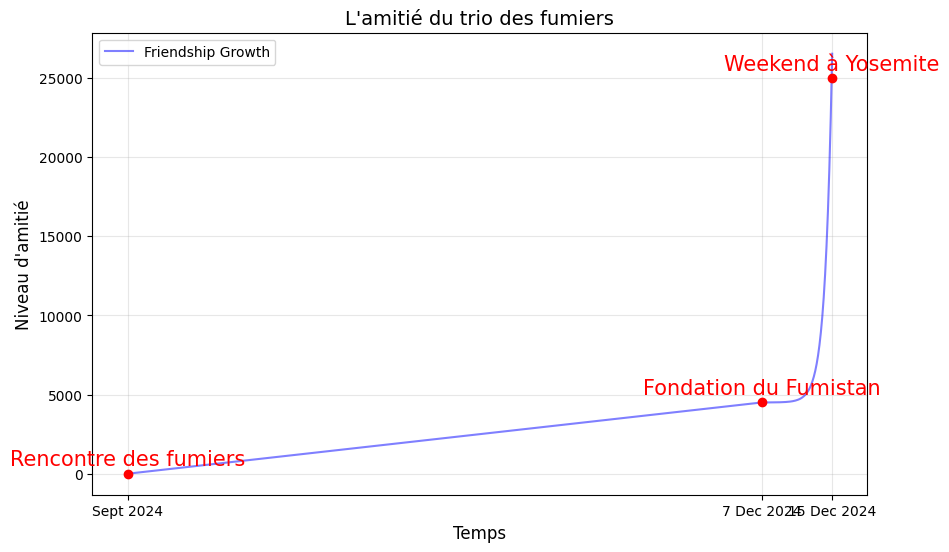

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Define the timeline
dates = ["Sept 2024", "7 Dec 2024", "15 Dec 2024"]
x_values = [0, 90, 100]
labels = ["Rencontre des fumiers", "Fondation du Fumistan", "Weekend à Yosemite"]
# Define friendship growth levels
y_values = [0, 90*50, 25000]

# Define the friendship curve
x_curve = np.linspace(0,100, 500)
y_curve = np.piecewise(
    x_curve,
    [x_curve <= 90, x_curve > 90],
    [lambda x: 50 * x, lambda x: 90*50+np.exp(x - 90)]
)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(x_curve, y_curve, label="Friendship Growth", color="blue", alpha=0.5)
plt.scatter(x_values, y_values, color="red", zorder=5)
for i, label in enumerate(labels):
    plt.text(x_values[i], y_values[i] + 500, label, ha='center', fontsize=15, color="red")

# Labeling and styling
plt.title("L'amitié du trio des fumiers", fontsize=14)
plt.xlabel("Temps", fontsize=12)
plt.ylabel("Niveau d'amitié", fontsize=12)
plt.xticks(x_values, dates)
plt.grid(alpha=0.3)
plt.legend()
plt.show()
